## Titanic Data Processing

Processamento dos dados de treino e teste do problema Titanic. Serão feitas:

1. inserção de dados faltosos ('Age')
2. exclusão de algumas características não pertinentes
3. Transição de tipos de dados categóricos/numéricos e vice-versa 

#### Leitura dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

datapaths = ["../data/train.csv", "../data/test.csv"]
datasets = [pd.read_csv(path) for path in datapaths]

#### Exclusão de dados não importantes

In [2]:
meaningless_features = ['Cabin', 'Ticket', 'Name', 'Fare']
for data in datasets:
    data.drop(meaningless_features , inplace=True, axis=1)

#### Categorias Gênero e Idade

In [3]:
genders = {"male": 1, "female": 0}
AGE_GROUPS = [0, 16, 36, 61, 200]
for data in datasets:
    data['AgeGroup']= pd.cut(data['Age'], bins=AGE_GROUPS, labels=False)
    data['Sex'] = data['Sex'].map(genders)

#### Modelo de predição de idade

In [4]:
full_age = pd.concat([ data[data['Age'].notna()] for data in datasets ])

y = full_age.AgeGroup
features = ['Pclass', 'SibSp', 'Parch']
X = full_age[features]

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
logmodel = LogisticRegression(random_state=42)
logmodel.fit(X_train,y_train)
test_preds = logmodel.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, test_preds))

Accuracy: 0.6624203821656051


#### Aplicação do modelo de predição de idade

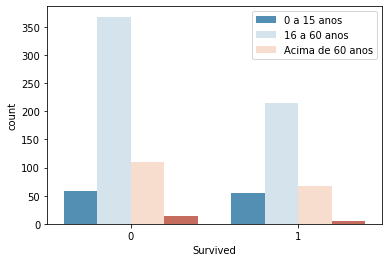

In [5]:
import pickle
from utils import impute_age_model

age_model = LogisticRegression(random_state=42)
age_model.fit(X,y)

with open('../models/age_model.pickle', 'wb') as p:
    pickle.dump(age_model, p)

for data in datasets:
    data['AgeGroup']= data[['AgeGroup', 'Pclass', 'SibSp', 'Parch']].apply(impute_age_model, axis=1).convert_dtypes()
LABELS = ["0 a 15 anos", "16 a 60 anos", "Acima de 60 anos"]
hist_surv_age_plt = sns.countplot(x='Survived',hue='AgeGroup', data=datasets[0], palette='RdBu_r')
plt.legend(labels=LABELS)
plt.show(hist_surv_age_plt)

#### Local de Embarque - *Imput* de dados e identificacao

<AxesSubplot:xlabel='Survived', ylabel='count'>

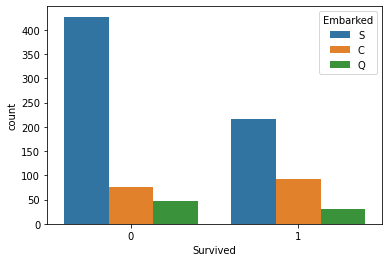

In [6]:
sns.countplot(x='Survived',hue='Embarked', data=datasets[0])

In [7]:
portos = datasets[0].Embarked.unique().tolist()
most_commom_idx = portos.index(datasets[0]["Embarked"].mode().tolist()[0])
embarked_groups = {}
for i, val in enumerate(portos):
    if type(val) == str:
        embarked_groups[val] = i
    else:
        embarked_groups[val] = most_commom_idx
for data in datasets:
    data['EmbarkedGroup'] = data['Embarked'].map(embarked_groups)


#### Triangulo de Correlações

<AxesSubplot:>

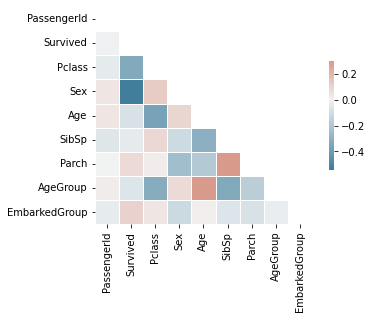

In [8]:
corr = datasets[0].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#### Final - Salvando .csv melhorados

In [9]:
datapaths = ["../data/train_upgrade.csv", "../data/test_upgrade.csv"]
for data, path in zip(datasets, datapaths):
    data.to_csv(path)